# Generate Honeycomb lattice

## Unitcell

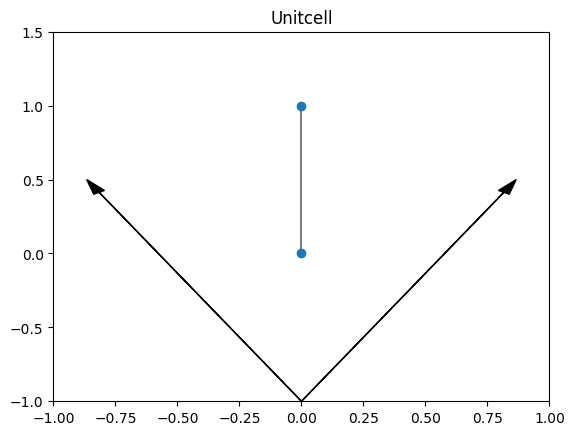

PyObject <matplotlib.text.Text object at 0x000000002DD2DC50>

In [131]:
basis = [[0.,0.],[0.,1.]] # we choose bond length = 1.0
a1 = [cos(deg2rad(30)), sin(deg2rad(30)) + 1]
a2 = a1.*[-1,1]

using PyPlot
pygui(false)
plot(getindex.(basis, 1), getindex.(basis, 2), color="gray")
scatter(getindex.(basis, 1), getindex.(basis, 2), zorder=5)
arrow(0,-sin(deg2rad(30))-0.5,a1..., head_width=0.05, head_length=0.1, fc="k", ec="k", length_includes_head=true)
arrow(0,-sin(deg2rad(30))-0.5,a2..., head_width=0.05, head_length=0.1, fc="k", ec="k", length_includes_head=true)
ylim([-1,1.5])
xlim([-1,1])
title("Unitcell")

## Calculate site positions, bonds etc.

In [10]:
# if length(ARGS) < 1 error("L argument missing") end
# L=parse(Int, ARGS[1])
L = 4
N=2*L^2
nbonds = Int(3*N/2)

basis = [[0.,0.],[0.,1.]] # bond length = 1
a1 = [cos(deg2rad(30)), sin(deg2rad(30)) + 1]
a2 = a1.*[-1,1]

# site positions
positions = Vector{Vector{Float64}}(N)
pi = 1
for ix in 0:L-1
    for iy in 0:L-1
        positions[pi] = basis[1]+(iy)*a1+ix*(a1-a2)
        positions[pi+1] = basis[2]+(iy)*a1+ix*(a1-a2)
        pi += 2
    end
end

# unit cells neighbortable
ucs = reshape(1:L^2, (L,L)) # unitcells form square lattice
downright = circshift(ucs, (+1,-1)) # down right bond
up = circshift(ucs, (-1,0)) # up "right" bond
ucneighs = vcat(downright[:]', up[:]') # column = unitcell linidx

getsite(uc::Int, site::Int) = 2 * (uc-1) + site

# bonds
bonds = Vector{Vector{Int}}(nbonds) # from, to, type
bondvecs = Vector{Vector{Float64}}(nbonds) # to_pos - from_pos
ibond = 1
for uc in 1:L^2
    # inner bond
    s1 = getsite(uc, 1)
    s2 = getsite(uc, 2)
    bonds[ibond] = [s1, s2, 0]
    bondvecs[ibond] = [0.0, 1.0]
    ibond += 1
    
    # down-right bond
    trg = getsite(ucneighs[1,uc],2)
    bonds[ibond] = [s1, trg, 1]
    bondvecs[ibond] = [0.8660254037844387, 0.5]
    ibond += 1
    
    # up-"right" bond
    trg = getsite(ucneighs[2,uc],1)
    bonds[ibond] = [s2, trg, 2]
    bondvecs[ibond] = [0.8660254037844387, -0.5]
    ibond += 1
end

## Plot lattice

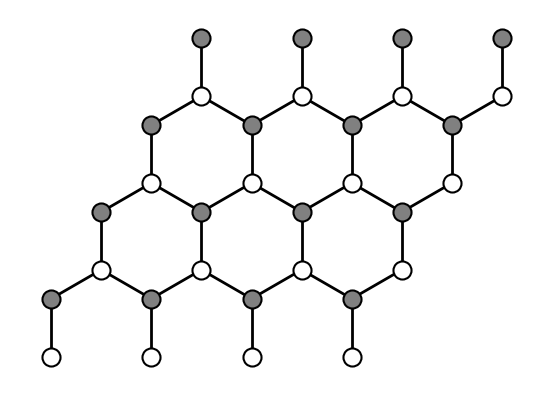

In [11]:
using PyPlot

# bondcolors=["C7", "C8", "C9"]
bondcolors=fill("black", 3)
sitecolors=["white", "gray"]

# plot bonds
for (ibond, b) in enumerate(bonds)
    src = positions[b[1]]
    trg = positions[b[2]]
    
    # don't show pbc bonds
    b[2] > b[1] || continue
    b[2] - b[1] < 2*L || continue

    plot([src[1], trg[1]], [src[2], trg[2]], color=bondcolors[b[3]+1], linewidth=2.0)
    gca()[:set_axis_off]()
end

# plot sites
for (s, pos) in enumerate(positions)
    stype = Int(iseven(s))+1
#     plot(pos..., marker="o", markersize=13, color=sitecolors[stype])
    plot(pos..., marker="o", markersize=13, color=sitecolors[stype], mec="black", mew=1.5)
end
# scatter(getindex.(positions, 1), getindex.(positions, 2), c=1:length(positions), cmap="Blues")

axis("equal")
savefig("honeycomb.pdf")

## Create ALPS like XML

In [181]:
using LightXML

# create an empty XML document
xdoc = XMLDocument()

# create & attach a graph (root) node
graph = create_root(xdoc, "GRAPH")
nedges = Int(3*N/2)
set_attributes(graph, dimension=2, vertices=N, edges=nedges)

function addvertex!(node, id, typ, coordinates)
    v = new_child(node, "VERTEX")
    set_attributes(v, Dict("id"=>id, "type"=>typ))

    vc = new_child(v, "COORDINATE")
    add_text(vc, "$(join(coordinates, " "))")
end

function addedge!(node, src, trg, id, typ, vector)
    edge = new_child(node, "EDGE")
    set_attributes(edge, id=id)
    set_attributes(edge, source=src, target=trg)
    set_attributes(edge, Dict("type"=>typ, "vector"=>join(vector, " ")))
end

# add vertices to graph
for (vi, pos) in enumerate(positions)
    addvertex!(graph, vi, Int(iseven(vi)), pos)
end

# add edges to graph
for (ibond, b) in enumerate(bonds)
    addedge!(graph, b[1], b[2], ibond, b[3], bondvecs[ibond])
end

# s = string(xdoc);
# print(xdoc)

save_file(xdoc, "honeycomb_L_$(L)_W_$(L).xml");
println("Done.")

Done.
